In [1]:
import imghdr
import tensorflow_hub as hub
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
#Kernel Intilizer
from sklearn.preprocessing import LabelEncoder
# import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam , Adamax
#PreTrained Model
from tensorflow.keras.applications import *
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mayankanand2701/zomato-stock-price-dataset

Dataset URL: https://www.kaggle.com/datasets/mayankanand2701/zomato-stock-price-dataset
License(s): MIT
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 32.8MB/s]


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir,calculate_results

--2024-05-24 04:30:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-05-24 04:30:07 (13.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
! wget https://raw.githubusercontent.com/jul1998/tensorflow_projects/main/scripts_for_tensorflow.py
from scripts_for_tensorflow import *

--2024-05-24 04:30:07--  https://raw.githubusercontent.com/jul1998/tensorflow_projects/main/scripts_for_tensorflow.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10534 (10K) [text/plain]
Saving to: ‘scripts_for_tensorflow.py’

scripts_for_tensorf 100%[===================>]  10.29K  --.-KB/s    in 0.001s  

2024-05-24 04:30:07 (8.63 MB/s) - ‘scripts_for_tensorflow.py’ saved [10534/10534]



In [5]:
unzip_data('/content/zomato-stock-price-dataset.zip')

In [6]:
# prompt: read csv with pandas

import pandas as pd

df = pd.read_csv('/content/Zomato Dataset.csv')
df.shape

(698, 7)

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,23-07-2021,116.000000,138.899994,115.000000,126.000000,126.000000,694895290
1,26-07-2021,126.349998,143.750000,125.300003,140.649994,140.649994,249723854
2,27-07-2021,141.699997,147.800003,127.750000,132.899994,132.899994,240341900
3,28-07-2021,131.000000,135.000000,123.550003,131.199997,131.199997,159793731
4,29-07-2021,134.949997,144.000000,132.199997,141.550003,141.550003,117973089


In [8]:
df = df.sort_values('Date')

In [10]:
data = df['Close'].values
data = data.reshape(-1, 1)
data[:10]

array([[124.5     ],
       [ 94.550003],
       [ 48.150002],
       [140.550003],
       [ 54.950001],
       [166.5     ],
       [ 84.300003],
       [184.5     ],
       [ 74.699997],
       [ 67.949997]])

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(data)
scaled_data[:10]

array([[0.51894768],
       [0.33134983],
       [0.04071406],
       [0.61948012],
       [0.08330723],
       [0.78202316],
       [0.26714689],
       [0.89476979],
       [0.20701531],
       [0.16473533]])

In [16]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [19]:
import numpy as np


# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_len = 60
x_train, y_train = create_sequences(train_data, seq_len)
x_test, y_test = create_sequences(test_data, seq_len)


In [21]:
len(x_train), len(x_test)

(498, 80)

In [23]:
# Reshape for LSTM input
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
x_train.shape

(498, 60, 1)

In [32]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_len, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Set early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/100
16/16 [==============================] - 6s 106ms/step - loss: 0.0867 - val_loss: 0.0625
Epoch 2/100
16/16 [==============================] - 1s 47ms/step - loss: 0.0690 - val_loss: 0.0591
Epoch 3/100
16/16 [==============================] - 1s 47ms/step - loss: 0.0661 - val_loss: 0.0585
Epoch 4/100
16/16 [==============================] - 1s 48ms/step - loss: 0.0656 - val_loss: 0.0581
Epoch 5/100
16/16 [==============================] - 1s 47ms/step - loss: 0.0657 - val_loss: 0.0587
Epoch 6/100
16/16 [==============================] - 1s 47ms/step - loss: 0.0660 - val_loss: 0.0579
Epoch 7/100
16/16 [==============================] - 1s 46ms/step - loss: 0.0671 - val_loss: 0.0577
Epoch 8/100
16/16 [==============================] - 1s 48ms/step - loss: 0.0659 - val_loss: 0.0572
Epoch 9/100
16/16 [==============================] - 1s 47ms/step - loss: 0.0656 - val_loss: 0.0573
Epoch 10/100
16/16 [==============================] - 1s 48ms/step - loss: 0.0648 - val_loss: 0.057

In [35]:
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

train_predictions = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

3/3 [==============================] - 0s 16ms/step


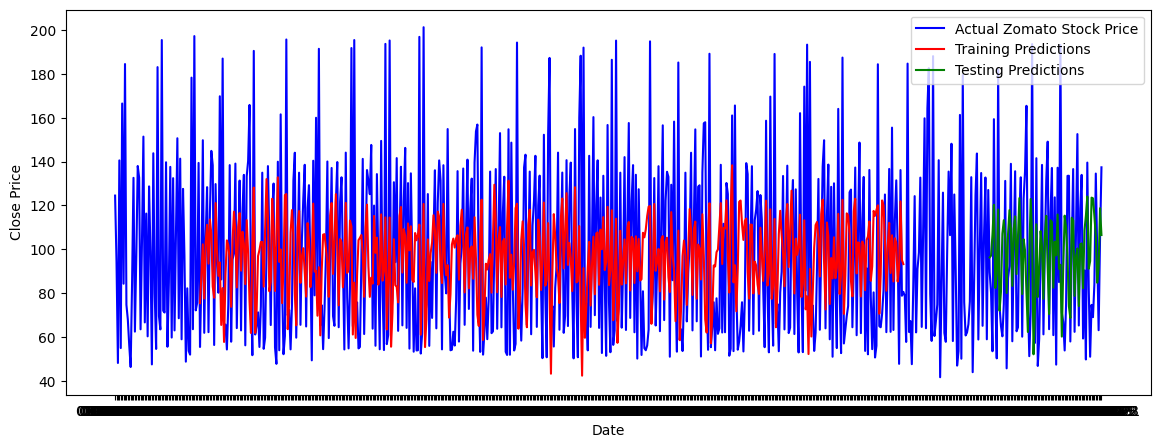

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(df['Date'], data, color='blue', label='Actual Zomato Stock Price')
train_dates = df['Date'][:train_size].values[seq_len:]
test_dates = df['Date'][train_size:].values[seq_len:]

plt.plot(train_dates, train_predictions, color='red', label='Training Predictions')
plt.plot(test_dates, test_predictions, color='green', label='Testing Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [40]:
 df['Date'][:train_size].values[seq_len:]

array(['03-08-2022', '03-08-2023', '03-09-2021', '03-10-2022',
       '03-10-2023', '03-11-2021', '03-11-2022', '03-11-2023',
       '03-12-2021', '04-01-2022', '04-01-2023', '04-01-2024',
       '04-02-2022', '04-03-2022', '04-03-2024', '04-04-2022',
       '04-04-2024', '04-05-2022', '04-05-2023', '04-07-2022',
       '04-07-2023', '04-08-2021', '04-08-2022', '04-08-2023',
       '04-09-2023', '04-10-2021', '04-10-2022', '04-10-2023',
       '04-11-2021', '04-11-2022', '04-12-2023', '05-01-2022',
       '05-01-2023', '05-01-2024', '05-02-2024', '05-03-2024',
       '05-04-2022', '05-04-2023', '05-04-2024', '05-05-2022',
       '05-05-2023', '05-06-2023', '05-07-2022', '05-07-2023',
       '05-08-2021', '05-08-2022', '05-09-2022', '05-09-2023',
       '05-10-2021', '05-10-2023', '05-12-2022', '05-12-2023',
       '06-01-2022', '06-01-2023', '06-02-2023', '06-02-2024',
       '06-03-2023', '06-03-2024', '06-04-2022', '06-04-2023',
       '06-05-2022', '06-05-2024', '06-06-2022', '06-06